#### Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

#### Setting the dataset path


In [2]:
#read DataSet
TrainImage="./Dataset/"

print(TrainImage)

./Dataset/


In [3]:
#to get all image names in train file
Noncovidimages = os.listdir(TrainImage + "/NONCOVID")
COVID19images = os.listdir(TrainImage + "/COVID19")

#### Explore the Data

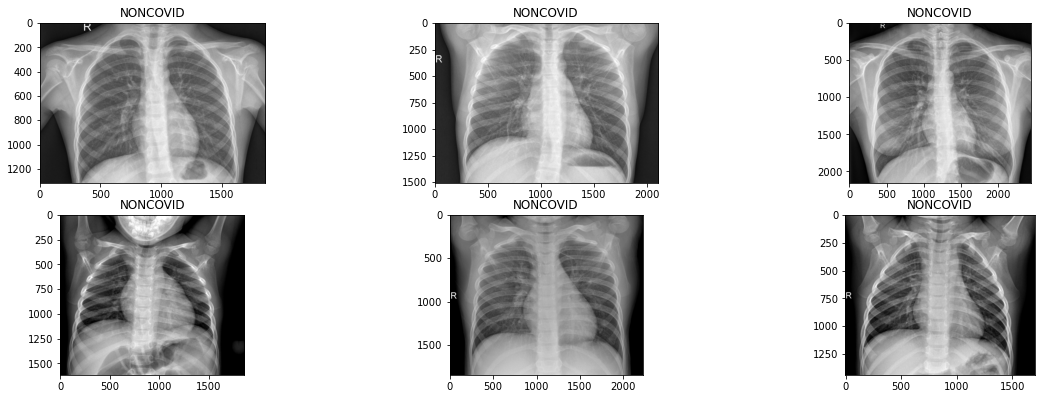

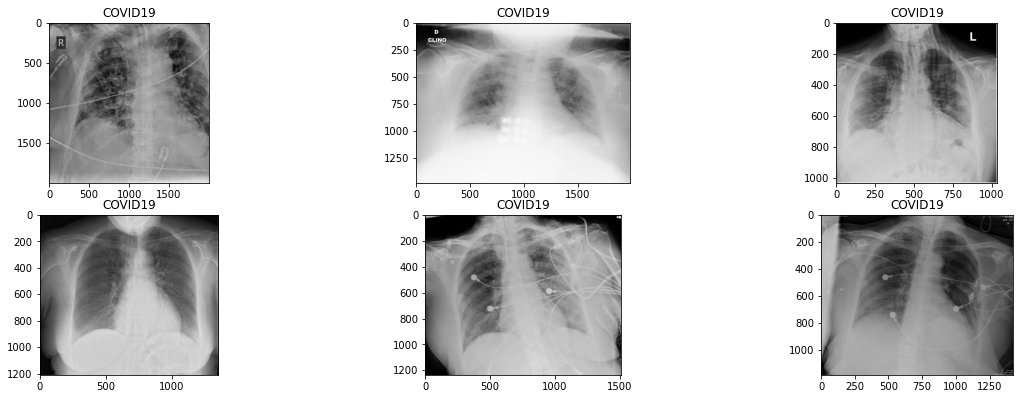

In [4]:
plt.show()
#plot NONCOVID
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NONCOVID",Noncovidimages[i])),cmap='gray')
    plt.title("NONCOVID")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

#### ImageDataGenerator (DataAugmentation )

In [6]:
Labels={'COVID19':0,'NONCOVID':1 }

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
               
#Test        
print(getCode('COVID19'))
print(getLabel(1))

0
NONCOVID


#### Load Data

In [8]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [9]:
#get train data
X_train, y_train = getData(TrainImage,sizeImage)

In [10]:
print("X_train Shape        ",X_train.shape)

X_train Shape         (6432, 300, 300, 3)


In [11]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)

y_train  (6432, 3)


In [12]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

#### Build Model

In [13]:
#load weight
Network_Weight="./DenseNet-BC-121-32-no-top.h5"
print(Network_Weight)

./DenseNet-BC-121-32-no-top.h5


In [14]:
from tensorflow.keras.applications.densenet import DenseNet121
pre_trained_model = DenseNet121(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)   

model = Model( pre_trained_model.input, x) 

# print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TruePositives(name='tp')])

#### K-fold Cross Validation

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from sklearn.model_selection import KFold

# K-fold Cross Validation model evaluation
num_folds = 5
fold_no = 1
epochs = 10
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)

import numpy as np
from sklearn.model_selection import KFold

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

C:\Users\supriti.ghosh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 378s 19s/step - loss: 1.9685 - accuracy: 0.8494 - auc: 0.8905 - precision: 0.8292 - Sensitivity: 0.8267 - tp: 2182.0952
Epoch 2/10
20/20 [==============================] - 367s 19s/step - loss: 0.1270 - accuracy: 0.9841 - auc: 0.9901 - precision: 0.9727 - Sensitivity: 0.9739 - tp: 2509.7143
Epoch 3/10
20/20 [==============================] - 368s 18s/step - loss: 0.0833 - accuracy: 0.9856 - auc: 0.9945 - precision: 0.9850 - Sensitivity: 0.9809 - tp: 2586.9524
Epoch 4/10
20/20 [==============================] - 370s 18s/step - loss: 0.0529 - accuracy: 0.9862 - auc: 0.9976 - precision: 0.9849 - Sensitivity: 0.9803 - tp: 2565.3333
Epoch 5/10
20/20 [==============================] - 367s 18s/step - loss: 0.0400 - accuracy: 0.9892 - auc: 0.9976 - precision: 0.9862 - Sensitivity: 0.9848 - tp: 2684.8095
Epoch 6/10
20/20 [==============================] - 364s 18s/step - loss: 0.0311 - accuracy: 0.9916 - auc: 0.9988 - precision: 0.9890 - Sens

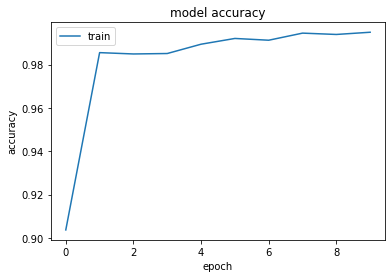

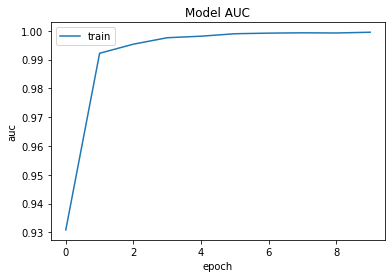

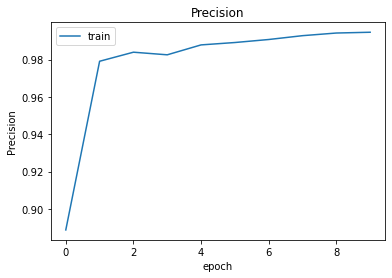

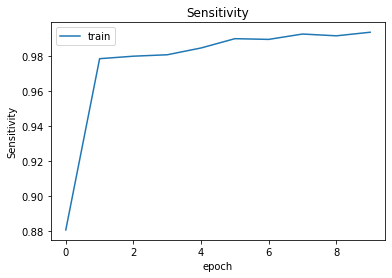

26/26 [==============================] - 98s 4s/step - loss: 0.0073 - accuracy: 0.9961 - auc: 1.0000 - precision: 0.9961 - Sensitivity: 0.9953 - tp: 1281.0000
Score for fold 1: loss of 0.00729455566033721; accuracy of 99.611496925354%; auc of 0.9999860525131226; precision of 0.9961119890213013; Sensitivity of 0.9953380227088928; tp of 1281.0
Epoch 1/10
20/20 [==============================] - 450s 20s/step - loss: 0.0162 - accuracy: 0.9947 - auc: 0.9996 - precision: 0.9949 - Sensitivity: 0.9928 - tp: 5083.0000
Epoch 2/10
20/20 [==============================] - 378s 19s/step - loss: 0.0131 - accuracy: 0.9957 - auc: 0.9996 - precision: 0.9955 - Sensitivity: 0.9951 - tp: 4865.0000
Epoch 3/10
20/20 [==============================] - 374s 18s/step - loss: 0.0137 - accuracy: 0.9941 - auc: 0.9995 - precision: 0.9929 - Sensitivity: 0.9945 - tp: 4862.0000
Epoch 4/10
20/20 [==============================] - 383s 19s/step - loss: 0.0120 - accuracy: 0.9959 - auc: 0.9997 - precision: 0.9953 - Sens

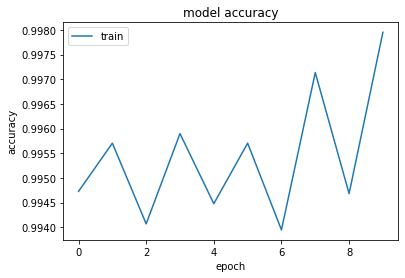

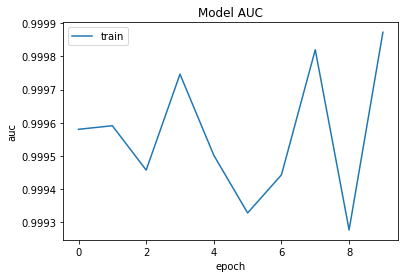

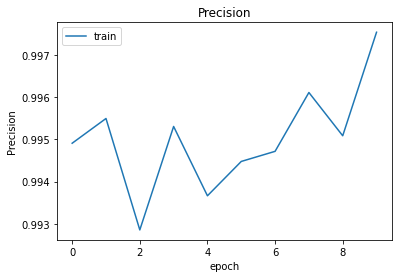

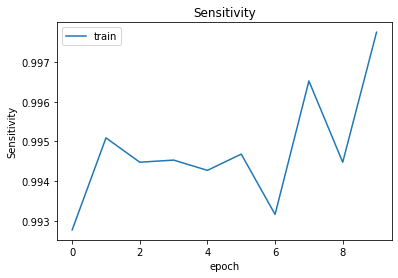

26/26 [==============================] - 98s 4s/step - loss: 0.0077 - accuracy: 0.9961 - auc: 0.9994 - precision: 0.9961 - Sensitivity: 0.9969 - tp: 1283.0000
Score for fold 2: loss of 0.007733324076980352; accuracy of 99.611496925354%; auc of 0.9993987083435059; precision of 0.9961180090904236; Sensitivity of 0.996891975402832; tp of 1283.0
Epoch 1/10
20/20 [==============================] - 480s 20s/step - loss: 0.0102 - accuracy: 0.9959 - auc: 0.9995 - precision: 0.9959 - Sensitivity: 0.9963 - tp: 4872.0000
Epoch 2/10
20/20 [==============================] - 380s 19s/step - loss: 0.0062 - accuracy: 0.9971 - auc: 0.9999 - precision: 0.9961 - Sensitivity: 0.9975 - tp: 4878.0000
Epoch 3/10
20/20 [==============================] - 386s 19s/step - loss: 0.0120 - accuracy: 0.9955 - auc: 0.9994 - precision: 0.9951 - Sensitivity: 0.9947 - tp: 5093.0000
Epoch 4/10
20/20 [==============================] - 373s 18s/step - loss: 0.0075 - accuracy: 0.9969 - auc: 0.9999 - precision: 0.9959 - Sens

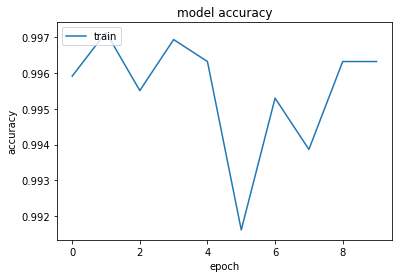

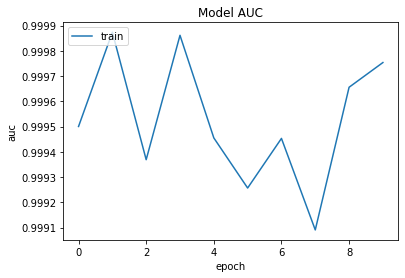

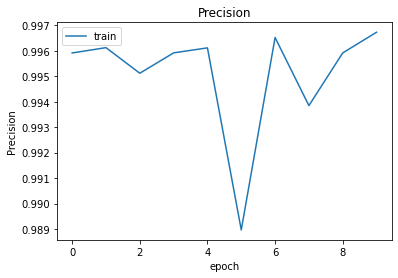

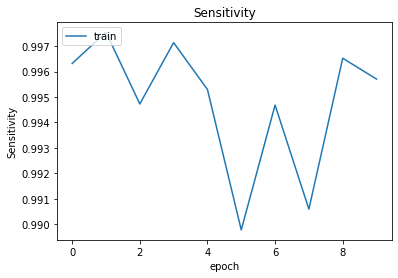

26/26 [==============================] - 101s 4s/step - loss: 0.0182 - accuracy: 0.9860 - auc: 0.9998 - precision: 0.9852 - Sensitivity: 0.9860 - tp: 1268.0000
Score for fold 3: loss of 0.018152140080928802; accuracy of 98.60031008720398%; auc of 0.9997770190238953; precision of 0.9852370023727417; Sensitivity of 0.9860031008720398; tp of 1268.0
Epoch 1/10
20/20 [==============================] - 620s 20s/step - loss: 0.0096 - accuracy: 0.9953 - auc: 0.9998 - precision: 0.9941 - Sensitivity: 0.9953 - tp: 4867.0000
Epoch 2/10
20/20 [==============================] - 379s 19s/step - loss: 0.0082 - accuracy: 0.9967 - auc: 0.9997 - precision: 0.9967 - Sensitivity: 0.9959 - tp: 4870.0000
Epoch 3/10
20/20 [==============================] - 404s 20s/step - loss: 0.0100 - accuracy: 0.9957 - auc: 0.9995 - precision: 0.9959 - Sensitivity: 0.9955 - tp: 5097.0000
Epoch 4/10
20/20 [==============================] - 387s 19s/step - loss: 0.0071 - accuracy: 0.9969 - auc: 0.9997 - precision: 0.9975 - 

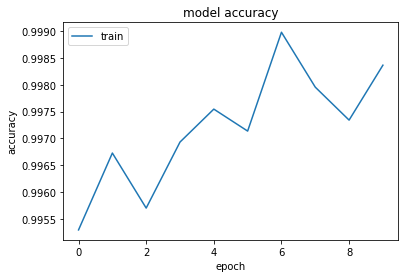

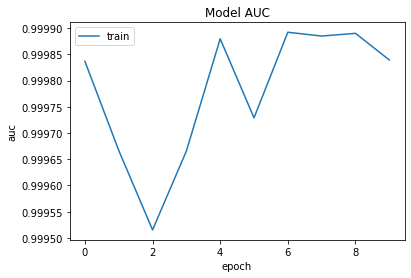

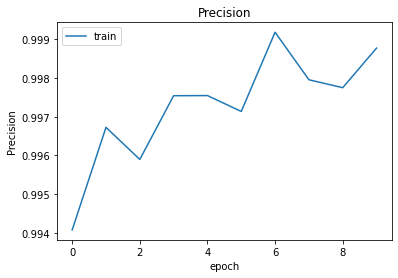

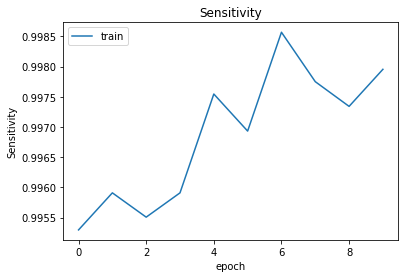

26/26 [==============================] - 102s 4s/step - loss: 0.0105 - accuracy: 0.9961 - auc: 0.9990 - precision: 0.9961 - Sensitivity: 0.9961 - tp: 1281.0000
Score for fold 4: loss of 0.010545387864112854; accuracy of 99.61119890213013%; auc of 0.9990150332450867; precision of 0.9961119890213013; Sensitivity of 0.9961119890213013; tp of 1281.0
Epoch 1/10
20/20 [==============================] - 420s 19s/step - loss: 0.0026 - accuracy: 0.9990 - auc: 0.9999 - precision: 0.9990 - Sensitivity: 0.9990 - tp: 4885.0000
Epoch 2/10
20/20 [==============================] - 379s 19s/step - loss: 0.0075 - accuracy: 0.9969 - auc: 0.9996 - precision: 0.9965 - Sensitivity: 0.9971 - tp: 4876.0000
Epoch 3/10
20/20 [==============================] - 377s 19s/step - loss: 0.0039 - accuracy: 0.9980 - auc: 0.9999 - precision: 0.9978 - Sensitivity: 0.9982 - tp: 4881.0000
Epoch 4/10
20/20 [==============================] - 373s 18s/step - loss: 0.0034 - accuracy: 0.9984 - auc: 1.0000 - precision: 0.9980 - 

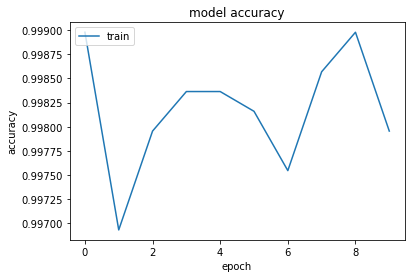

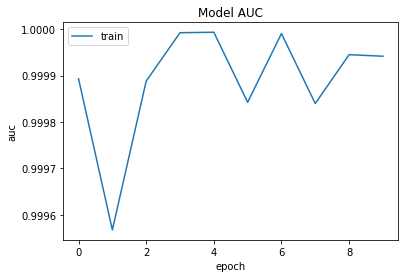

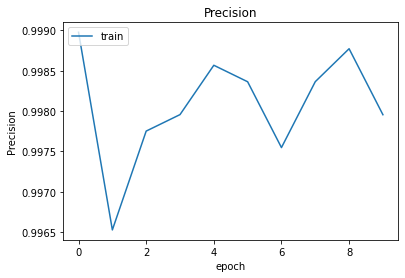

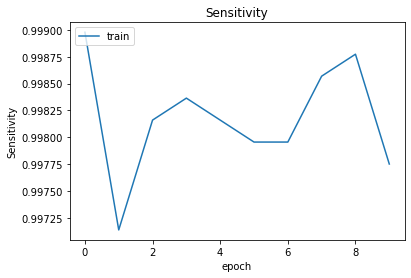

26/26 [==============================] - 100s 4s/step - loss: 0.0065 - accuracy: 0.9969 - auc: 0.9994 - precision: 0.9969 - Sensitivity: 0.9969 - tp: 1282.0000
Score for fold 5: loss of 0.006499211769551039; accuracy of 99.6889591217041%; auc of 0.9994044899940491; precision of 0.996889591217041; Sensitivity of 0.996889591217041; tp of 1282.0


In [20]:
score_list = []

for train, test in kfold.split(X_train, y_train):
    
    train_generator =train_datagen.flow(
         X_train[train], y_train[train],
         batch_size= 256
    )

    test_generator =train_datagen.flow(
         X_train[test], y_train[test],
         batch_size= 50
    )  
    
    history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
             epochs=epochs)


    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['auc'])
    plt.title('Model AUC')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['Sensitivity'])
    plt.title('Sensitivity')
    plt.ylabel('Sensitivity')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # Generate generalization metrics
    scores = model.evaluate(test_generator)
    score_list.append(scores)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

In [21]:
for s in score_list:
    print(s[1]*100)

99.611496925354
99.611496925354
98.60031008720398
99.61119890213013
99.6889591217041
